In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split

# Models
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier

# Cross-validation/gridserch tools
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV


# Model fine-tuning and evaluation
from sklearn.model_selection import StratifiedKFold, learning_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn import model_selection



# Pipiline tools
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

#Deal with outliers
from sklearn.preprocessing import RobustScaler



import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore sklearn/seaborn deprecation warning 

Precision is a good measure to determine, when the costs of False Positive is high.

In [2]:
df= pd.read_csv('./dataset/users.csv')

df.set_index('id', inplace=True) #set id as df index

# New features 

#ratio_outcome_income
df['ratio_outcome_income']= df['monthly_income']/df['monthly_outcome']

#sqrt  
df['sqrt_income']= df['monthly_income']**(1/2)
df['sqrt_outcome']= df['monthly_outcome']**(1/2)

#log
df['log_income']= df['monthly_income'].map(lambda i: np.log(i))
df['log_outcome']= df['monthly_outcome'].map(lambda i: np.log(i))

In [3]:
# Split target feature

X = df.drop(labels = ["class"],axis = 1)
y = df['class']

#There is not imbalance between class 1 and class 0.
(df['class'].sum())/ (df['class'].count())

0.535

/Users/rene/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


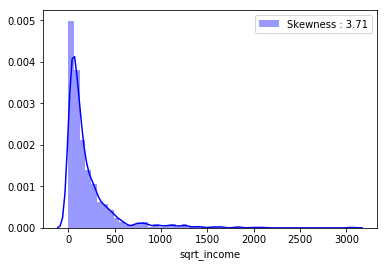

In [4]:
# The features does not follow a normal distrubtion, 
# i.e. wealth is not normally distributed.
# Hence below we first focus on models that do not make such assumption. 
temp=df[(df['monthly_income'] >100000) ]['monthly_income']
temp=df['sqrt_income']

sns.distplot(temp, color="b", label="Skewness : %.2f"%(temp.skew())).legend(loc="best")


In [5]:
scaler = StandardScaler()
X_SS = pd.DataFrame(scaler.fit_transform(X), index=X.index, columns=X.columns) # Helps the most

transformer = RobustScaler().fit(X)
X_RS = pd.DataFrame(transformer.transform(X), index=X.index, columns=X.columns) # Helps marginally

X_train, X_test, y_train, y_test = train_test_split(X_SS, y, test_size=0.2, random_state=42)

# Modeling Round 1

In [6]:
# Initiate 11 classifier models
ran = RandomForestClassifier(random_state=1)
knn = KNeighborsClassifier()
log = LogisticRegression()
xgb = XGBClassifier()
gbc = GradientBoostingClassifier()
svc = SVC(probability=True)
ext = ExtraTreesClassifier()
ada = AdaBoostClassifier()
gnb = GaussianNB()
gpc = GaussianProcessClassifier()
bag = BaggingClassifier()


models_names=['Random Forest', 'K Nearest Neighbour', 
              'Logistic Regression', 'XGBoost', 
              'Gradient Boosting', 'SVC', 'Extra Trees', 
              'AdaBoost', 'Gaussian Naive Bayes', 
              'Gaussian Process', 'Bagging Classifier']



# Prepare lists and dictionary for future use
models = [ran, knn, log, xgb, gbc, svc, ext, ada, gnb, gpc, bag]         
scores = []
models_dict = dict(zip(models_names, models))

# Sequentially fit and cross validate all models
for mod in models:
    mod.fit(X_train, y_train)
    acc = cross_val_score(mod, X_train, y_train, scoring ='precision', cv = 10)
    scores.append(acc.mean())

/Users/rene/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/rene/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


## Cross validation presicion scores

In [7]:
# Creating a table of results, ranked highest to lowest
results = pd.DataFrame({
    'Model': models_names,
    'Score': scores})

result_df = results.sort_values(by='Score', ascending=False).reset_index(drop=True)
result_df.head(11)


,Model,Score
0,Gaussian Naive Bayes,0.733390
1,Logistic Regression,0.669562
2,Gaussian Process,0.665552
3,SVC,0.656779
4,XGBoost,0.654629
5,Gradient Boosting,0.641792
6,AdaBoost,0.640482
7,Bagging Classifier,0.637148
8,K Nearest Neighbour,0.630143
9,Random Forest,0.602904


(0.6, 0.74)

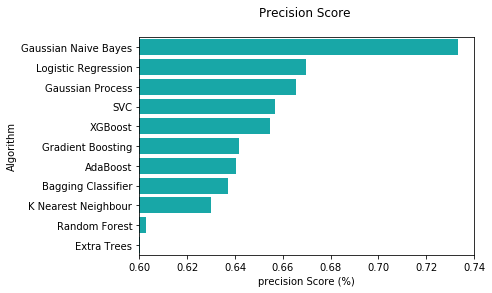

In [8]:
sns.barplot(x='Score', y = 'Model', data = result_df, color = 'c')
plt.title('Precision Score \n')
plt.xlabel('precision Score (%)')
plt.ylabel('Algorithm')
plt.xlim(0.60, 0.74)

## Feature importance

In [9]:
# Function for new graph
def importance_plotting(data, x, y, palette, title):
    sns.set(style="whitegrid")
    ft = sns.PairGrid(data, y_vars=y, x_vars=x, size=5, aspect=1.5)
    ft.map(sns.stripplot, orient='h', palette=palette, edgecolor="black", size=15)
    
    for ax, title in zip(ft.axes.flat, titles):
    # Set a different title for each axes
        ax.set(title=title)
    # Make the grid horizontal instead of vertical
        ax.xaxis.grid(False)
        ax.yaxis.grid(True)
    plt.show()


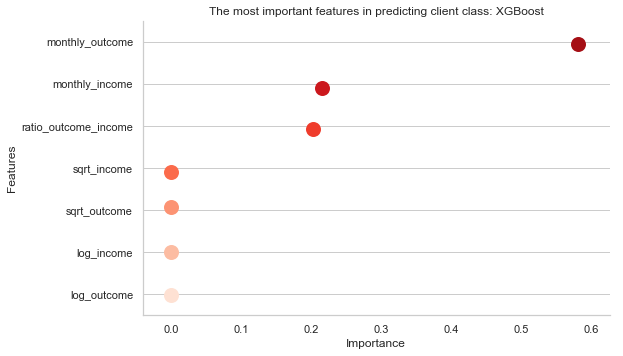

In [10]:
# Building feature importance into a DataFrame
fi = {'Features':X.columns.tolist(), 'Importance':xgb.feature_importances_}
importance = pd.DataFrame(fi, index=None).sort_values('Importance', ascending=False)

# Creating graph title
titles = ['The most important features in predicting client class: XGBoost']

# Plotting graph
importance_plotting(importance, 'Importance', 'Features', 'Reds_r', titles)

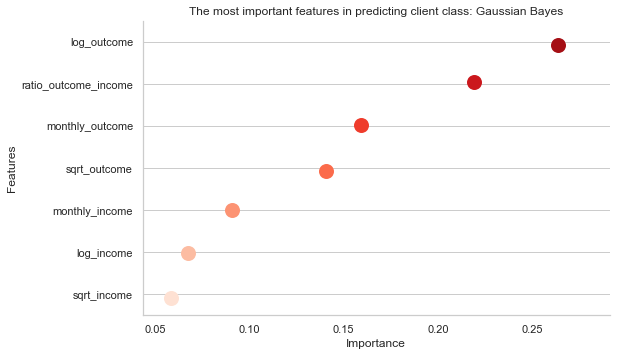

In [11]:
# Building feature importance into a DataFrame
fi = {'Features':X.columns.tolist(), 'Importance':gbc.feature_importances_}
importance = pd.DataFrame(fi, index=None).sort_values('Importance', ascending=False)

# Creating graph title
titles = ['The most important features in predicting client class: Gaussian Bayes']

# Plotting graph
importance_plotting(importance, 'Importance', 'Features', 'Reds_r', titles)

Something is seriesouly wrong here because the feature importance is very different in both cases. Let's next study the learning curves:

In [12]:
kfold = StratifiedKFold(n_splits=5,shuffle=True, random_state=42)

def plot_learning_curve(estimator, title, X, y, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)

    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="b")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="b",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

## Learning curves

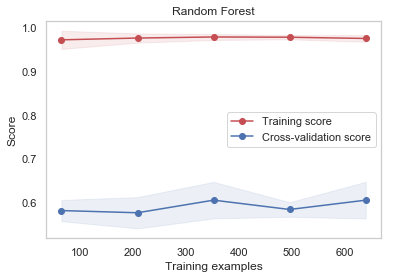

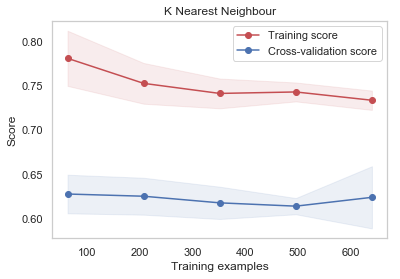

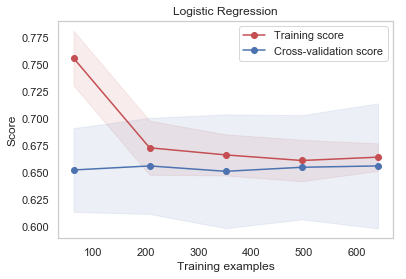

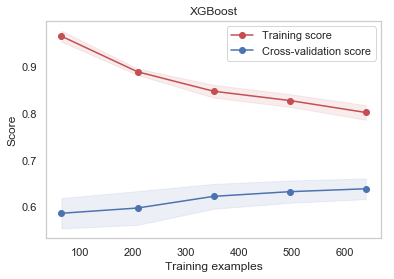

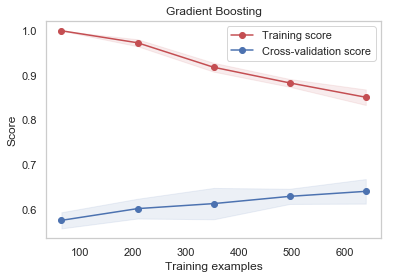

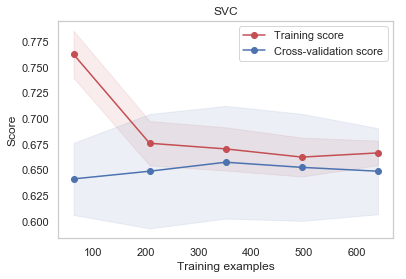

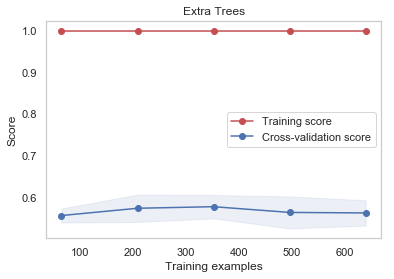

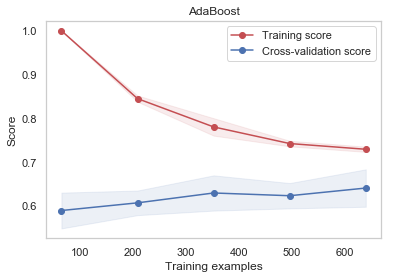

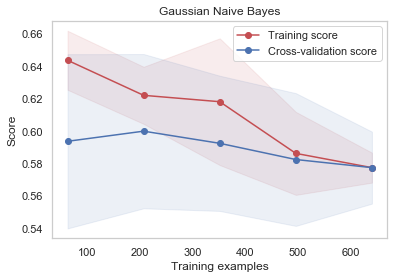

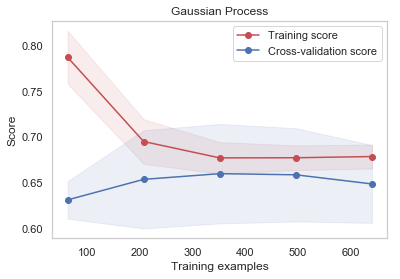

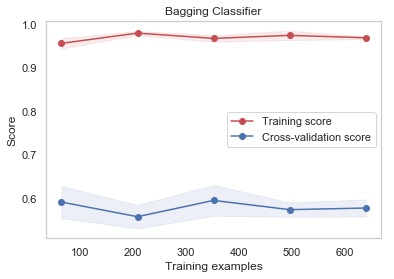

In [13]:
for i in models_names:
    plot_learning_curve(models_dict[i],i,X_train, y_train,cv=kfold)

Learnign curves show that the only models without a Variance problem are:
- Logistic regression
- Support Vector Classifier
- Gaussian process
- AdaBoost

# Modeling Round 2: Feature selection 

In [14]:
# Getting feature importances models that include feature_importances_ method
gbc_imp = pd.DataFrame({'Feature':X.columns, 'gbc importance':gbc.feature_importances_})
xgb_imp = pd.DataFrame({'Feature':X.columns, 'xgb importance':xgb.feature_importances_})
ran_imp = pd.DataFrame({'Feature':X.columns, 'ran importance':ran.feature_importances_})
ext_imp = pd.DataFrame({'Feature':X.columns, 'ext importance':ext.feature_importances_})
ada_imp = pd.DataFrame({'Feature':X.columns, 'ada importance':ada.feature_importances_})

# Merging results into a single dataframe
importances = gbc_imp.merge(xgb_imp, on='Feature').merge(ran_imp, on='Feature').merge(ext_imp, on='Feature').merge(ada_imp, on='Feature')

# Calculating average importance per feature
importances['Average'] = importances.mean(axis=1)

# Ranking top to bottom
importances = importances.sort_values(by='Average', ascending=False).reset_index(drop=True)

# Display
importances

,Feature,gbc importance,xgb importance,ran importance,ext importance,ada importance,Average
0,monthly_outcome,0.159277,0.581127,0.137506,0.134983,0.18,0.238579
1,ratio_outcome_income,0.219261,0.203092,0.136358,0.137715,0.28,0.195285
2,log_outcome,0.263851,0.000000,0.207079,0.196950,0.16,0.165576
3,monthly_income,0.090705,0.215781,0.134858,0.127074,0.10,0.133683
4,sqrt_outcome,0.140903,0.000000,0.148447,0.163247,0.16,0.122519
5,log_income,0.067372,0.000000,0.121035,0.127897,0.06,0.075261
6,sqrt_income,0.058630,0.000000,0.114717,0.112135,0.06,0.069096


## Model retraining

In [15]:
# Drop redundant features

# Re-build model variables
X_v2=X.drop(['log_income', 'sqrt_income','monthly_income'], axis=1,inplace = False)
scaler = StandardScaler()
X_SS_v2 = pd.DataFrame(scaler.fit_transform(X_v2), index=X_v2.index, columns=X_v2.columns) # Helps the most



X_train, X_test, y_train, y_test = train_test_split(X_SS_v2, y, test_size=0.2, random_state=42)

scores_v2=[]
for mod in models:
    mod.fit(X_train, y_train)
    acc = cross_val_score(mod, X_train, y_train, scoring = "precision", cv = 10)
    scores_v2.append(acc.mean())

In [16]:
# Creating a table of results, ranked highest to lowest
results = pd.DataFrame({
    'Model': models_names,
    'Original Score': scores,
    'Score with feature selection': scores_v2})

result_df = results.sort_values(by='Score with feature selection', ascending=False).reset_index(drop=True)
result_df.head(11)

,Model,Original Score,Score with feature selection
0,Gaussian Naive Bayes,0.733390,0.693966
1,K Nearest Neighbour,0.630143,0.675580
2,Logistic Regression,0.669562,0.672106
3,Gaussian Process,0.665552,0.661004
4,SVC,0.656779,0.660213
5,XGBoost,0.654629,0.652029
6,AdaBoost,0.640482,0.646288
7,Gradient Boosting,0.641792,0.639649
8,Extra Trees,0.600477,0.629986
9,Bagging Classifier,0.637148,0.626739


# Modeling Round 3: (hyper-parameter) tuning

In [17]:
models_dict_v3={}

In [18]:
# Random Forest

# Parameter's to search
n_estimators = [10, 25, 50, 75, 100]
max_depth = [3, None]
max_features = [1, 3, 5, 7]
min_samples_split = [2, 4, 6, 8, 10]
min_samples_leaf = [2, 4, 6, 8, 10]


# Setting up parameter grid
hyperparams = {'n_estimators': n_estimators, 'max_depth': max_depth, 
               'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf}

# Run GridSearch CV
gd=GridSearchCV(estimator = RandomForestClassifier(), param_grid = hyperparams, 
                cv=5, scoring = "precision")

# Fitting model and return results
gd.fit(X_train, y_train)
print(gd.best_score_)
models_dict_v3[models_names[0]]= gd.best_estimator_

print(models_dict_v3[models_names[0]])

0.6680955375842923
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=6, min_samples_split=6,
            min_weight_fraction_leaf=0.0, n_estimators=75, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [19]:
# KNeighborsClassifier


# Parameter's to search
n_neighbors = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20]
algorithm = ['auto']
weights = ['uniform', 'distance']
leaf_size = [1, 2, 3, 4, 5, 10, 15, 20, 25, 30]

# Setting up parameter grid
hyperparams = {'algorithm': algorithm, 'weights': weights, 'leaf_size': leaf_size, 
               'n_neighbors': n_neighbors}

# Run GridSearch CV
gd=GridSearchCV(estimator = KNeighborsClassifier(), param_grid = hyperparams, 
                    cv=5, scoring = "precision")

# Fitting model and return results
gd.fit(X_train, y_train)
print(gd.best_score_)
models_dict_v3[models_names[1]]= gd.best_estimator_

print(models_dict_v3[models_names[1]])

0.6834270785783139
KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=4, p=2,
           weights='uniform')


In [20]:
#Logistic regression

# Parameter's to search
penalty = ['l1', 'l2']
C = np.logspace(0, 4, 10)

# Setting up parameter grid
hyperparams = {'penalty': penalty, 'C': C}

# Run GridSearch CV
gd=GridSearchCV(estimator = LogisticRegression(), param_grid = hyperparams, 
                    cv=5, scoring = "precision")

# Fitting model and return results
gd.fit(X_train, y_train)
print(gd.best_score_)
models_dict_v3[models_names[2]]= gd.best_estimator_

print(models_dict_v3[models_names[2]])

0.6697564854916693
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


In [21]:
#XGBoost

max_depth = [3, 5, 7, 9, 10]
min_child_weight = [2, 3, 5, 6]


hyperparams = {'max_depth': max_depth, 'min_child_weight': min_child_weight,"n_estimators": [90,100,110],
              'reg_alpha':[1e-3, 1e-2, 0.1],"learning_rate": [0.05,0.1]}


gd=GridSearchCV(estimator = XGBClassifier(learning_rate=0.0001, n_estimators=10), param_grid = hyperparams, 
                                           cv=5, scoring = "precision", n_jobs = 4)

gd.fit(X_train, y_train)
print(gd.best_score_)
models_dict_v3[models_names[3]]= gd.best_estimator_

print(models_dict_v3[models_names[3]])

0.6699791170029264
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=5, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0.1,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)


In [22]:
# Parameter's to search
learning_rate = [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2]
n_estimators = [100, 250, 500, 750, 1000, 1500]

# Setting up parameter grid
hyperparams = {'learning_rate': learning_rate, 'n_estimators': n_estimators}

# Run GridSearch CV
gd=GridSearchCV(estimator = GradientBoostingClassifier(), param_grid = hyperparams, 
                    cv=5, scoring = "precision", n_jobs=4)

# Fitting model and return results
gd.fit(X_train, y_train)
print(gd.best_score_)
models_dict_v3[models_names[4]]= gd.best_estimator_

print(models_dict_v3[models_names[4]])

0.6470881025230816
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)


In [23]:

#SVC

# Parameter's to search
Cs = [0.001, 0.01, 0.1, 1, 5, 10, 15, 20, 50, 100]
gammas = [0.001, 0.01, 0.1, 1]

# Setting up parameter grid
hyperparams = {'C': Cs, 'gamma' : gammas}

# Run GridSearch CV
gd=GridSearchCV(estimator = SVC(probability=True), param_grid = hyperparams, 
                cv=5, scoring = "precision", n_jobs= 4)

# Fitting model and return results
gd.fit(X_train, y_train)
print(gd.best_score_)
models_dict_v3[models_names[5]]= gd.best_estimator_

print(models_dict_v3[models_names[5]])


0.6699508240297714
SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [24]:
# Extra trees

# Parameter's to search
n_estimators = [10, 25, 50, 75, 100]
max_depth = [3, None]

min_samples_split = [2, 4, 6, 8, 10]
min_samples_leaf = [2, 4, 6, 8, 10]

# Setting up parameter grid
hyperparams = {'n_estimators': n_estimators, 'max_depth': max_depth,
               'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf}

# Run GridSearch CV
gd=GridSearchCV(estimator = ExtraTreesClassifier(), param_grid = hyperparams, 
                cv=5, scoring = "precision", n_jobs=4)

# Fitting model and return results
gd.fit(X_train, y_train)
print(gd.best_score_)

models_dict_v3[models_names[6]]= gd.best_estimator_
print(models_dict_v3[models_names[6]])

0.6789258574591637
ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=3, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=4, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)


In [25]:
# Parameter's to search
n_estimators = [10, 25, 50, 75, 100, 125, 150, 200]
learning_rate = [0.001, 0.01, 0.1, 0.5, 1, 1.5, 2]

# Setting up parameter grid
hyperparams = {'n_estimators': n_estimators, 'learning_rate': learning_rate}

# Run GridSearch CV
gd=GridSearchCV(estimator = AdaBoostClassifier(), param_grid = hyperparams, 
                cv=5, scoring = "precision", n_jobs = 4)

# Fitting model and return results
gd.fit(X_train, y_train)
print(gd.best_score_)

models_dict_v3[models_names[7]]= gd.best_estimator_
print(models_dict_v3[models_names[7]])

0.6596471332798199
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=2,
          n_estimators=125, random_state=None)


In [26]:
#Gaussian Naive Bayes

models_dict_v3[models_names[8]]= gnb

print(models_dict_v3[models_names[8]])


GaussianNB(priors=None, var_smoothing=1e-09)


In [27]:
# Gaussian Process

# Parameter's to search
n_restarts_optimizer = [0, 1, 2, 3]
max_iter_predict = [1, 2, 5, 10, 20, 35, 50, 100]
warm_start = [True, False]

# Setting up parameter grid
hyperparams = {'n_restarts_optimizer': n_restarts_optimizer, 'max_iter_predict': max_iter_predict, 'warm_start': warm_start}

# Run GridSearch CV
gd=GridSearchCV(estimator = GaussianProcessClassifier(), param_grid = hyperparams, 
                cv=5, scoring = "precision", n_jobs=4)

# Fitting model and return results
gd.fit(X_train, y_train)
print(gd.best_score_)

models_dict_v3[models_names[9]]= gd.best_estimator_
print(models_dict_v3[models_names[9]])

0.6661073801994223
GaussianProcessClassifier(copy_X_train=True, kernel=None, max_iter_predict=1,
             multi_class='one_vs_rest', n_jobs=None,
             n_restarts_optimizer=0, optimizer='fmin_l_bfgs_b',
             random_state=None, warm_start=True)


In [28]:
# Baggin classifier

# Parameter's to search
n_estimators = [10, 15, 20, 25, 50, 75, 100, 150]
max_samples = [1, 2, 3, 5, 7, 10, 15, 20, 25, 30, 50]
max_features = [1, 3, 5, 7]

# Setting up parameter grid
hyperparams = {'n_estimators': n_estimators, 'max_samples': max_samples}

# Run GridSearch CV
gd=GridSearchCV(estimator = BaggingClassifier(), param_grid = hyperparams, 
                cv=5, scoring = "precision", n_jobs=4)

# Fitting model and return results
gd.fit(X_train, y_train)
print(gd.best_score_)

models_dict_v3[models_names[10]]= gd.best_estimator_
print(models_dict_v3[models_names[10]])

0.710267335004177
BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=5,
         n_estimators=20, n_jobs=None, oob_score=False, random_state=None,
         verbose=0, warm_start=False)


In [29]:
scores_v3=[]
for mod in models_dict_v3:
    models_dict_v3[mod].fit(X_train, y_train)
    acc = cross_val_score(models_dict_v3[mod], X_train, y_train, scoring = "precision", cv = 5)
    scores_v3.append(acc.mean())

In [30]:
# Creating a table of results, ranked highest to lowest
results = pd.DataFrame({
    'Model': models_names,
    'Original Score': scores,
    'Score with feature selection': scores_v2,
    'Score with tuned parameters': scores_v3})

result_df = results.sort_values(by='Score with tuned parameters', ascending=False).reset_index(drop=True)
result_df.head(11)

,Model,Original Score,Score with feature selection,Score with tuned parameters
0,Bagging Classifier,0.637148,0.626739,0.698989
1,Gaussian Naive Bayes,0.733390,0.693966,0.684427
2,K Nearest Neighbour,0.630143,0.675580,0.683427
3,XGBoost,0.654629,0.652029,0.669979
4,SVC,0.656779,0.660213,0.669951
5,Logistic Regression,0.669562,0.672106,0.669756
6,Gaussian Process,0.665552,0.661004,0.666107
7,AdaBoost,0.640482,0.646288,0.658907
8,Random Forest,0.602904,0.626472,0.656845
9,Gradient Boosting,0.641792,0.639649,0.647088


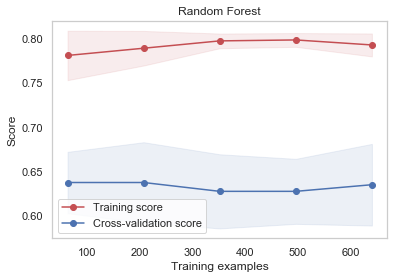

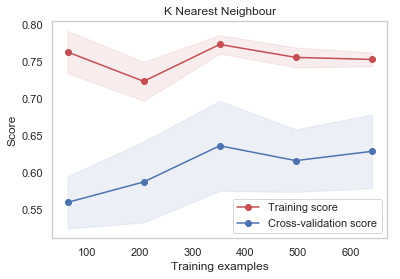

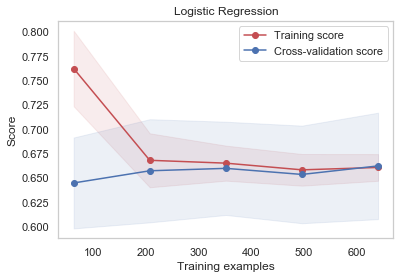

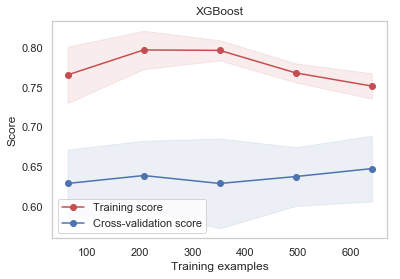

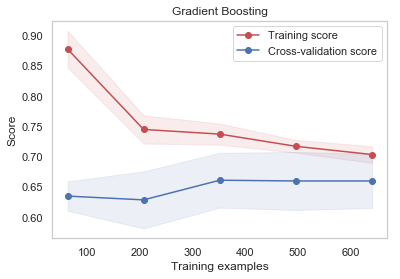

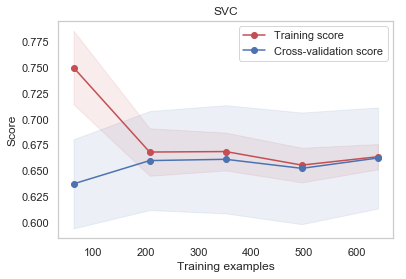

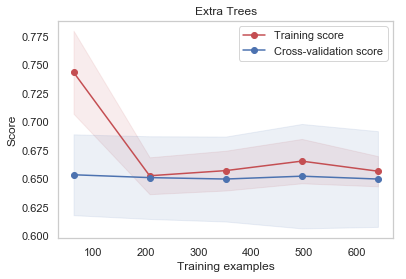

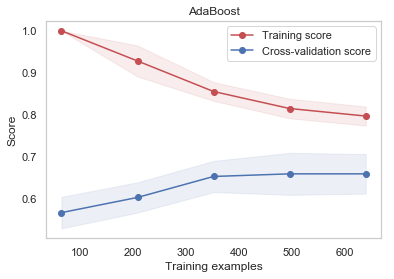

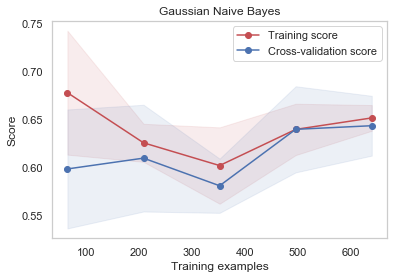

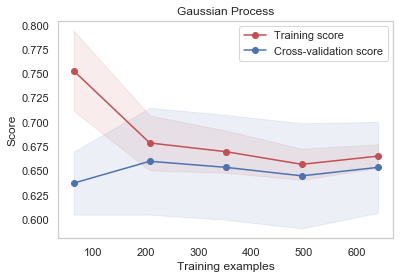

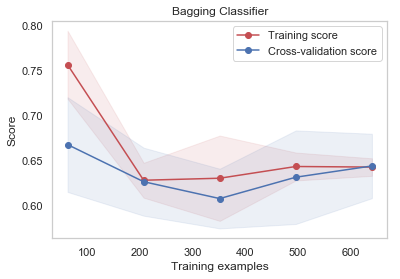

In [31]:
for i in models_names:
    plot_learning_curve(models_dict_v3[i], i , X_train, y_train,cv=kfold)

# Precision on testing set

In [32]:
from sklearn.metrics import precision_score
scores_test=[]
for mod in models_dict_v3:
    predictions=(models_dict_v3[mod].predict(X_test))
    scores_test.append(precision_score(y_test,predictions))


In [33]:
# Creating a table of results, ranked highest to lowest
results = pd.DataFrame({
    'Model': models_names,
    'Score with feature selection and tuned hy-parameters': scores_v3,
    'Score on test set': scores_test})

result_df = results.sort_values(by='Score on test set', ascending=False).reset_index(drop=True)
result_df.head(11)

,Model,Score with feature selection and tuned hy-parameters,Score on test set
0,Gaussian Naive Bayes,0.684427,0.740260
1,Random Forest,0.656845,0.649123
2,XGBoost,0.669979,0.647059
3,Gaussian Process,0.666107,0.643478
4,Logistic Regression,0.669756,0.641026
5,K Nearest Neighbour,0.683427,0.635417
6,SVC,0.669951,0.626016
7,Extra Trees,0.634273,0.614815
8,AdaBoost,0.658907,0.611511
9,Bagging Classifier,0.698989,0.597122


In [34]:
## Definitely better than random! But not high enough. 

# Blending models through voting.

In [35]:
# split blending train/cv

votingC = VotingClassifier(estimators= list(models_dict_v3.items()) , voting='hard', n_jobs = -1)

cv_result=cross_val_score(votingC, X_train, y = y_train, scoring = 'precision', cv = kfold, n_jobs = -1)

cv_result.mean(), cv_result.std()


(0.6586574619143886, 0.04845217073963211)

In [36]:
# So final precision we got from this data set is:

votingC = votingC.fit(X_train, y_train)
precision_score(y_test, votingC.predict(X_test))

0.6271186440677966